# Audio UX

Task mAIstro supports voice interactions using:
- [OpenAI's Whisper](https://platform.openai.com/docs/guides/speech-to-text) for speech-to-text
- [ElevenLabs](https://github.com/elevenlabs/elevenlabs-python) for text-to-speech

### Install dependencies

Ensure you have `ffmpeg` installed for using ElevenLabs. 

On MacOS, you can install it with `brew install ffmpeg`. 

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core sounddevice scipy elevenlabs 

### Set environment variables

* Set your `OPENAI_API_KEY`
* Set your `ELEVENLABS_API_KEY` (available [here](https://elevenlabs.io/api))
* Optional: Set your `LANGCHAIN_API_KEY` (available [here](https://smith.langchain.com/)) if you want tracing or want to connect with a hosted deployment.

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
_set_env("ELEVENLABS_API_KEY")
_set_env("WHISSLE_AUTH_TOKEN")

import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "task-maistro-deployment"

### Connect to your deployment

Connect to your deployment using the URL endpoint:
- **Studio**: Found in Studio UI 
- **CLI**: Printed to console (typically `http://localhost:8123`)
- **Cloud**: Available in LangGraph Deployment page

We'll connect to the deployment as a [RemoteGraph](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#how-to-interact-with-the-deployment-using-remotegraph). 


In [2]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Local deployment (via LangGraph Studio)
local_deployment_url = "http://localhost:64083"

# Deployment URL
cloud_deployment_url = "https://task-maistro-1b681add7a2b549499bb0cd21a7e5be4.default.us.langgraph.app"

# Graph name
graph_name = "task_maistro" 

# Connect to the deployment
remote_graph = RemoteGraph(graph_name, url=local_deployment_url)

You can test your deployment by running the following. 

In [3]:
# Int
user_input = "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old."
config = {"configurable": {"user_id": "Test-Deployment-User"}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.
================================== Ai Message ==================================

Hello Lance! It's great to meet you. If there's anything specific you need help with, like managing tasks or organizing your schedule, feel free to let me know!


### Add audio

Our deployed graph has some benefits: 
* It has built-in support for long-term memory 
* It implements all the logic for task mAIstro 

But, we have a challenge:
* It takes test as input and returns text as output

We need to add audio input and output to the graph. So, we'll simply add two nodes to our graph:

1. **Audio Input Node**
   * Records microphone input (stop with Enter)
   * Transcribes speech using Whisper
   * Passes text to Task mAIstro

2. **Audio Output Node**
   * Takes Task mAIstro's text response
   * Converts to speech via ElevenLabs
   * Plays audio response

We can achieve this by embedding our deployed graph [as a node](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#using-as-a-subgraph) in a new graph. 

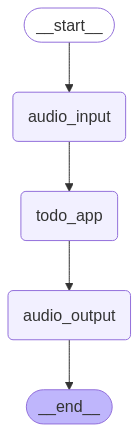

In [7]:
import io
import threading
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from IPython.display import Image, display

from whissle import WhissleClient

from elevenlabs import play, VoiceSettings
from elevenlabs.client import ElevenLabs

from langgraph.graph import StateGraph, MessagesState, END, START

# Initialize Whissle client
whissle_client = WhissleClient().sync_client


# Initialize ElevenLabs client
elevenlabs_client = ElevenLabs(api_key=os.getenv("ELEVENLABS_API_KEY"))


def record_audio_until_stop(state: MessagesState):
    """Records audio from microphone until Enter is pressed, saves to a .wav file, then processes it."""

    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000  # (kHz) Adequate for human voice frequency
    audio_file_path = "input_audio.wav"  # Path to save the audio file

    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array
    audio_data = np.concatenate(audio_data, axis=0)

    # Save the audio data to a local WAV file
    write(audio_file_path, sample_rate, audio_data)
    print(f"Audio saved to {audio_file_path}")

    transcription = whissle_client.speech_to_text(
        audio_file_path,
        model_name="en-US-0.6b",
        timestamps=False,
        boosted_lm_words=["reformer"],
        boosted_lm_score=80,
    )

    # Print the transcription
    print("Here is the transcription:", transcription.transcript)

    # Return the transcription as a message
    return {"messages": [HumanMessage(content=transcription.transcript)]}

def play_audio(state: MessagesState):
    
    """Plays the audio response from the remote graph with ElevenLabs."""

    # Response from the agent 
    response = state['messages'][-1]

    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in ElevenLabs
    cleaned_text = response.content.replace("**", "")
    
    # Call text_to_speech API with turbo model for low latency
    response = elevenlabs_client.text_to_speech.convert(
        voice_id="pNInz6obpgDQGcFmaJgB", # Adam pre-made voice
        output_format="mp3_22050_32",
        text=cleaned_text,
        model_id="eleven_turbo_v2_5", 
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )
    
    # Play the audio back
    play(response)

# Define parent graph
builder = StateGraph(MessagesState)

# Add remote graph directly as a node
builder.add_node("audio_input", record_audio_until_stop)
builder.add_node("todo_app", remote_graph)
builder.add_node("audio_output", play_audio)
builder.add_edge(START, "audio_input")
builder.add_edge("audio_input", "todo_app")
builder.add_edge("todo_app","audio_output")
builder.add_edge("audio_output",END)
graph = builder.compile()

display(Image(graph.get_graph(xray=0).draw_mermaid_png()))

Optionally, you can supply a thread ID to ensure that conversation history is persisted. 

In [8]:
import uuid
thread_id = str(uuid.uuid4())

Simply, run this cell and speak into your microphone. When you are finished, press Enter.

In [9]:
# Set user ID for storing memories
config = {"configurable": {"user_id": "Test-Audio-UX", "thread_id": thread_id}}

# Kick off the graph, which will record user input until the user presses Enter
for chunk in graph.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Follow the user's instructions:
Recording your instruction! ... Press Enter to stop recording.
Audio saved to input_audio.wav
{'transcript': 'Hi, how are you doing? ', 'duration_seconds': 2.1760001182556152, 'timestamps': [], 'language_code': 'en'}
Here is the transcription: Hi, how are you doing? 
================================ Human Message =================================

Hi, how are you doing? 
================================== Ai Message ==================================

Hello! I'm here and ready to help you with your tasks. How can I assist you today?
